In [1]:
# AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=25
n_units=512
l2Regularizer=1e-09
kernel_size1 = 2
kernel_size2 = 5
n_grid = 101
strides = 2
input_size = 49

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out')

In [7]:
origin = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin_data)
folders = [file for file in folders_orig if file.startswith('airfoil')]

In [9]:
coord_df = pd.DataFrame()
counter = 1
for i in range(1, 134):
    coord_file_name = origin_coord + "\\airfoil" + str(i) + "\\airfoilOut"+ str(i) + ".txt"
    data = pd.read_csv(coord_file_name, sep = ",", header=None)
    while counter < 17:
        coord_df = pd.concat([coord_df, data], axis=0)
        counter += 1
    counter=1

In [10]:
coord_np = coord_df.iloc[:, :].values

In [11]:
coord = coord_np.reshape((len(folders), 16, 2, 50))

In [12]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [13]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [14]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [15]:
y = y.reshape((133, 16, 2, 1))

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [17]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [18]:
geometry.shape

(2128, 1)

In [19]:
geometry = geometry.reshape((133, 16, 1))

In [20]:
x_train_orig, x_test, aa_train_orig, aa_test, geo_train_orig, geo_test, y_train_orig, y_test = train_test_split(
    coord, aa, geometry, y, test_size=0.1, random_state=1)

In [21]:
x_train, x_val, aa_train, aa_val, geo_train, geo_val, y_train, y_val = train_test_split(x_train_orig, aa_train_orig, geo_train_orig,
                                                                                        y_train_orig, test_size=0.3, random_state=1)

In [22]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_val = x_val.reshape((x_val.shape[0]*x_val.shape[1], x_val.shape[2], x_val.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_val = aa_val.reshape((aa_val.shape[0]*aa_val.shape[1], aa_val.shape[2], aa_val.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_val = geo_val.reshape((geo_val.shape[0]*geo_val.shape[1], geo_val.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_val = y_val.reshape((y_val.shape[0]*y_val.shape[1], y_val.shape[2], y_val.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [23]:
input_coord = tf.keras.Input(shape=(2, 50, 1))
input_alpha = tf.keras.Input(shape=(1,1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer')(input_coord)
x_ = tf.keras.layers.MaxPooling2D((1,2))(x_conv)
reshape1 = tf.keras.layers.Flatten()(x_)
reshape2 = tf.keras.layers.Reshape((1,))(input_alpha)
x_concat = tf.keras.layers.Concatenate(axis=1)([reshape1, reshape2])

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_concat)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayerSensor')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-I
model = tf.keras.Model([input_coord, input_alpha], output_image)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 50, 1)]   0           []                               
                                                                                                  
 Conv2DLayer (Conv2D)           (None, 1, 25, 25)    275         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 12, 25)    0           ['Conv2DLayer[0][0]']            
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                              

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [26]:
start = datetime.datetime.now()
history = model.fit([x_train,aa_train], y_train, validation_data=([x_val, aa_val], y_val), epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
42/42 [==============================] - 3s 9ms/step - loss: 0.0707 - rmse: 0.2659 - val_loss: 0.0190 - val_rmse: 0.1379
Epoch 2/5000
42/42 [==============================] - 0s 5ms/step - loss: 0.0150 - rmse: 0.1223 - val_loss: 0.0155 - val_rmse: 0.1245
Epoch 3/5000
42/42 [==============================] - 0s 5ms/step - loss: 0.0122 - rmse: 0.1105 - val_loss: 0.0113 - val_rmse: 0.1062
Epoch 4/5000
42/42 [==============================] - 0s 5ms/step - loss: 0.0105 - rmse: 0.1023 - val_loss: 0.0098 - val_rmse: 0.0989
Epoch 5/5000
42/42 [==============================] - 0s 5ms/step - loss: 0.0111 - rmse: 0.1053 - val_loss: 0.0095 - val_rmse: 0.0976
Epoch 6/5000
42/42 [==============================] - 0s 6ms/step - loss: 0.0099 - rmse: 0.0994 - val_loss: 0.0111 - val_rmse: 0.1054
Epoch 7/5000
42/42 [==============================] - 0s 6ms/step - loss: 0.0103 - rmse: 0.1017 - val_loss: 0.0100 - val_rmse: 0.1002
Epoch 8/5000
42/42 [==============================] - 0s 6ms/s

Epoch 62/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0050 - rmse: 0.0706 - val_loss: 0.0070 - val_rmse: 0.0836
Epoch 63/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0049 - rmse: 0.0702 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 64/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0055 - rmse: 0.0744 - val_loss: 0.0075 - val_rmse: 0.0866
Epoch 65/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0055 - rmse: 0.0739 - val_loss: 0.0069 - val_rmse: 0.0833
Epoch 66/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0050 - rmse: 0.0704 - val_loss: 0.0069 - val_rmse: 0.0833
Epoch 67/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0055 - rmse: 0.0739 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 68/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0052 - rmse: 0.0721 - val_loss: 0.0071 - val_rmse: 0.0845
Epoch 69/5000
42/42 [==============================] - 

42/42 [==============================] - 0s 8ms/step - loss: 0.0042 - rmse: 0.0645 - val_loss: 0.0064 - val_rmse: 0.0802
Epoch 123/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0046 - rmse: 0.0681 - val_loss: 0.0070 - val_rmse: 0.0837
Epoch 124/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0045 - rmse: 0.0671 - val_loss: 0.0071 - val_rmse: 0.0845
Epoch 125/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0042 - rmse: 0.0649 - val_loss: 0.0067 - val_rmse: 0.0817
Epoch 126/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0045 - rmse: 0.0671 - val_loss: 0.0070 - val_rmse: 0.0838
Epoch 127/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0044 - rmse: 0.0665 - val_loss: 0.0075 - val_rmse: 0.0867
Epoch 128/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0042 - rmse: 0.0646 - val_loss: 0.0066 - val_rmse: 0.0815
Epoch 129/5000
42/42 [==============================] - 0s 8ms/

42/42 [==============================] - 0s 8ms/step - loss: 0.0043 - rmse: 0.0657 - val_loss: 0.0072 - val_rmse: 0.0846
Epoch 183/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0038 - rmse: 0.0614 - val_loss: 0.0064 - val_rmse: 0.0801
Epoch 184/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0039 - rmse: 0.0626 - val_loss: 0.0065 - val_rmse: 0.0804
Epoch 185/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0036 - rmse: 0.0600 - val_loss: 0.0068 - val_rmse: 0.0823
Epoch 186/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0038 - rmse: 0.0616 - val_loss: 0.0077 - val_rmse: 0.0876
Epoch 187/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0040 - rmse: 0.0631 - val_loss: 0.0074 - val_rmse: 0.0861
Epoch 188/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0041 - rmse: 0.0637 - val_loss: 0.0071 - val_rmse: 0.0845
Epoch 189/5000
42/42 [==============================] - 0s 8ms/

42/42 [==============================] - 0s 8ms/step - loss: 0.0035 - rmse: 0.0596 - val_loss: 0.0082 - val_rmse: 0.0904
Epoch 243/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0037 - rmse: 0.0605 - val_loss: 0.0069 - val_rmse: 0.0832
Epoch 244/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0034 - rmse: 0.0586 - val_loss: 0.0071 - val_rmse: 0.0845
Epoch 245/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0035 - rmse: 0.0592 - val_loss: 0.0070 - val_rmse: 0.0839
Epoch 246/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0037 - rmse: 0.0605 - val_loss: 0.0073 - val_rmse: 0.0856
Epoch 247/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0069 - val_rmse: 0.0831
Epoch 248/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0034 - rmse: 0.0586 - val_loss: 0.0067 - val_rmse: 0.0820
Epoch 249/5000
42/42 [==============================] - 0s 8ms/

42/42 [==============================] - 0s 8ms/step - loss: 0.0030 - rmse: 0.0551 - val_loss: 0.0085 - val_rmse: 0.0923
Epoch 303/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0031 - rmse: 0.0557 - val_loss: 0.0071 - val_rmse: 0.0842
Epoch 304/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0028 - rmse: 0.0528 - val_loss: 0.0071 - val_rmse: 0.0844
Epoch 305/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0030 - rmse: 0.0548 - val_loss: 0.0071 - val_rmse: 0.0844
Epoch 306/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0028 - rmse: 0.0533 - val_loss: 0.0074 - val_rmse: 0.0860
Epoch 307/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0032 - rmse: 0.0567 - val_loss: 0.0070 - val_rmse: 0.0836
Epoch 308/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0072 - val_rmse: 0.0849
Epoch 309/5000
42/42 [==============================] - 0s 8ms/

42/42 [==============================] - 0s 8ms/step - loss: 0.0026 - rmse: 0.0515 - val_loss: 0.0075 - val_rmse: 0.0864
Epoch 363/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0026 - rmse: 0.0506 - val_loss: 0.0077 - val_rmse: 0.0879
Epoch 364/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0026 - rmse: 0.0513 - val_loss: 0.0077 - val_rmse: 0.0879
Epoch 365/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0026 - rmse: 0.0512 - val_loss: 0.0076 - val_rmse: 0.0871
Epoch 366/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0024 - rmse: 0.0494 - val_loss: 0.0075 - val_rmse: 0.0864
Epoch 367/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0027 - rmse: 0.0521 - val_loss: 0.0081 - val_rmse: 0.0897
Epoch 368/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0075 - val_rmse: 0.0863
Epoch 369/5000
42/42 [==============================] - 0s 8ms/

42/42 [==============================] - 0s 8ms/step - loss: 0.0022 - rmse: 0.0469 - val_loss: 0.0075 - val_rmse: 0.0866
Epoch 423/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0021 - rmse: 0.0461 - val_loss: 0.0083 - val_rmse: 0.0909
Epoch 424/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0030 - rmse: 0.0549 - val_loss: 0.0080 - val_rmse: 0.0892
Epoch 425/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0024 - rmse: 0.0493 - val_loss: 0.0072 - val_rmse: 0.0849
Epoch 426/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0080 - val_rmse: 0.0897
Epoch 427/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0073 - val_rmse: 0.0856
Epoch 428/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0468 - val_loss: 0.0075 - val_rmse: 0.0865
Epoch 429/5000
42/42 [==============================] - 0s 8ms/

42/42 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0438 - val_loss: 0.0079 - val_rmse: 0.0887
Epoch 483/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0085 - val_rmse: 0.0921
Epoch 484/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0480 - val_loss: 0.0082 - val_rmse: 0.0907
Epoch 485/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0494 - val_loss: 0.0085 - val_rmse: 0.0920
Epoch 486/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0469 - val_loss: 0.0078 - val_rmse: 0.0882
Epoch 487/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0449 - val_loss: 0.0081 - val_rmse: 0.0898
Epoch 488/5000
42/42 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0429 - val_loss: 0.0083 - val_rmse: 0.0909
Epoch 489/5000
42/42 [==============================] - 0s 7ms/

42/42 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0085 - val_rmse: 0.0921
Epoch 543/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0080 - val_rmse: 0.0896
Epoch 544/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0400 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 545/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0082 - val_rmse: 0.0904
Epoch 546/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0436 - val_loss: 0.0075 - val_rmse: 0.0866
Epoch 547/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0386 - val_loss: 0.0081 - val_rmse: 0.0898
Epoch 548/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0381 - val_loss: 0.0074 - val_rmse: 0.0861
Epoch 549/5000
42/42 [==============================] - 0s 8ms/

42/42 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0379 - val_loss: 0.0081 - val_rmse: 0.0900
Epoch 603/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0386 - val_loss: 0.0081 - val_rmse: 0.0902
Epoch 604/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0391 - val_loss: 0.0082 - val_rmse: 0.0905
Epoch 605/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0079 - val_rmse: 0.0891
Epoch 606/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0441 - val_loss: 0.0095 - val_rmse: 0.0973
Epoch 607/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0414 - val_loss: 0.0079 - val_rmse: 0.0888
Epoch 608/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0376 - val_loss: 0.0080 - val_rmse: 0.0896
Epoch 609/5000
42/42 [==============================] - 0s 8ms/

42/42 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 0.0080 - val_rmse: 0.0897
Epoch 663/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0332 - val_loss: 0.0077 - val_rmse: 0.0879
Epoch 664/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0336 - val_loss: 0.0086 - val_rmse: 0.0927
Epoch 665/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0365 - val_loss: 0.0085 - val_rmse: 0.0922
Epoch 666/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0360 - val_loss: 0.0080 - val_rmse: 0.0894
Epoch 667/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0356 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 668/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0373 - val_loss: 0.0079 - val_rmse: 0.0891
Epoch 669/5000
42/42 [==============================] - 0s 8ms/

42/42 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0332 - val_loss: 0.0085 - val_rmse: 0.0923
Epoch 723/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0317 - val_loss: 0.0084 - val_rmse: 0.0914
Epoch 724/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0334 - val_loss: 0.0080 - val_rmse: 0.0896
Epoch 725/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0330 - val_loss: 0.0079 - val_rmse: 0.0888
Epoch 726/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0330 - val_loss: 0.0083 - val_rmse: 0.0912
Epoch 727/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0085 - val_rmse: 0.0919
Epoch 728/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0401 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 729/5000
42/42 [==============================] - 0s 8ms/

Epoch 782/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.5769e-04 - rmse: 0.0292 - val_loss: 0.0083 - val_rmse: 0.0912
Epoch 783/5000
42/42 [==============================] - 0s 8ms/step - loss: 9.7135e-04 - rmse: 0.0311 - val_loss: 0.0083 - val_rmse: 0.0910
Epoch 784/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0323 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 785/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0320 - val_loss: 0.0084 - val_rmse: 0.0918
Epoch 786/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0337 - val_loss: 0.0083 - val_rmse: 0.0910
Epoch 787/5000
42/42 [==============================] - 0s 8ms/step - loss: 9.1194e-04 - rmse: 0.0302 - val_loss: 0.0083 - val_rmse: 0.0910
Epoch 788/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 789/5000
42/42 [==============

42/42 [==============================] - 0s 8ms/step - loss: 8.2961e-04 - rmse: 0.0288 - val_loss: 0.0084 - val_rmse: 0.0916
Epoch 842/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0319 - val_loss: 0.0084 - val_rmse: 0.0914
Epoch 843/5000
42/42 [==============================] - 0s 8ms/step - loss: 9.4974e-04 - rmse: 0.0308 - val_loss: 0.0083 - val_rmse: 0.0910
Epoch 844/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.9218e-04 - rmse: 0.0298 - val_loss: 0.0086 - val_rmse: 0.0928
Epoch 845/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.2285e-04 - rmse: 0.0286 - val_loss: 0.0080 - val_rmse: 0.0897
Epoch 846/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.1975e-04 - rmse: 0.0286 - val_loss: 0.0080 - val_rmse: 0.0892
Epoch 847/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.7835e-04 - rmse: 0.0279 - val_loss: 0.0084 - val_rmse: 0.0917
Epoch 848/5000
42/42 [=================

42/42 [==============================] - 0s 8ms/step - loss: 9.2593e-04 - rmse: 0.0304 - val_loss: 0.0081 - val_rmse: 0.0902
Epoch 901/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.2046e-04 - rmse: 0.0268 - val_loss: 0.0077 - val_rmse: 0.0877
Epoch 902/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.0766e-04 - rmse: 0.0284 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 903/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.7597e-04 - rmse: 0.0259 - val_loss: 0.0083 - val_rmse: 0.0909
Epoch 904/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.2903e-04 - rmse: 0.0250 - val_loss: 0.0081 - val_rmse: 0.0900
Epoch 905/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.0430e-04 - rmse: 0.0265 - val_loss: 0.0081 - val_rmse: 0.0899
Epoch 906/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.2979e-04 - rmse: 0.0288 - val_loss: 0.0083 - val_rmse: 0.0913
Epoch 907/5000
42/42 [=============

Epoch 959/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.8657e-04 - rmse: 0.0280 - val_loss: 0.0082 - val_rmse: 0.0906
Epoch 960/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.8719e-04 - rmse: 0.0262 - val_loss: 0.0080 - val_rmse: 0.0897
Epoch 961/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.5803e-04 - rmse: 0.0256 - val_loss: 0.0084 - val_rmse: 0.0916
Epoch 962/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.5687e-04 - rmse: 0.0275 - val_loss: 0.0085 - val_rmse: 0.0924
Epoch 963/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.8583e-04 - rmse: 0.0280 - val_loss: 0.0084 - val_rmse: 0.0918
Epoch 964/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.1804e-04 - rmse: 0.0248 - val_loss: 0.0080 - val_rmse: 0.0897
Epoch 965/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.6766e-04 - rmse: 0.0277 - val_loss: 0.0084 - val_rmse: 0.0914
Epoch 966/5000
42/42

42/42 [==============================] - 0s 8ms/step - loss: 6.8765e-04 - rmse: 0.0262 - val_loss: 0.0081 - val_rmse: 0.0898
Epoch 1018/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0319 - val_loss: 0.0083 - val_rmse: 0.0913
Epoch 1019/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0336 - val_loss: 0.0081 - val_rmse: 0.0899
Epoch 1020/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0322 - val_loss: 0.0080 - val_rmse: 0.0897
Epoch 1021/5000
42/42 [==============================] - 0s 7ms/step - loss: 8.1024e-04 - rmse: 0.0284 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 1022/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.6856e-04 - rmse: 0.0258 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 1023/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.2474e-04 - rmse: 0.0249 - val_loss: 0.0084 - val_rmse: 0.0917
Epoch 1024/5000
42/42 [==================

42/42 [==============================] - 0s 8ms/step - loss: 7.5589e-04 - rmse: 0.0274 - val_loss: 0.0090 - val_rmse: 0.0951
Epoch 1076/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.3596e-04 - rmse: 0.0271 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 1077/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.4328e-04 - rmse: 0.0253 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 1078/5000
42/42 [==============================] - 0s 8ms/step - loss: 9.3677e-04 - rmse: 0.0306 - val_loss: 0.0079 - val_rmse: 0.0889
Epoch 1079/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.8844e-04 - rmse: 0.0298 - val_loss: 0.0086 - val_rmse: 0.0926
Epoch 1080/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.4940e-04 - rmse: 0.0254 - val_loss: 0.0084 - val_rmse: 0.0915
Epoch 1081/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.2702e-04 - rmse: 0.0269 - val_loss: 0.0083 - val_rmse: 0.0913
Epoch 1082/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 7.9116e-04 - rmse: 0.0281 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 1134/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.8985e-04 - rmse: 0.0298 - val_loss: 0.0084 - val_rmse: 0.0916
Epoch 1135/5000
42/42 [==============================] - 0s 8ms/step - loss: 9.2723e-04 - rmse: 0.0304 - val_loss: 0.0084 - val_rmse: 0.0916
Epoch 1136/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.9439e-04 - rmse: 0.0299 - val_loss: 0.0086 - val_rmse: 0.0929
Epoch 1137/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.0751e-04 - rmse: 0.0265 - val_loss: 0.0082 - val_rmse: 0.0907
Epoch 1138/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.7245e-04 - rmse: 0.0217 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 1139/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.4585e-04 - rmse: 0.0254 - val_loss: 0.0084 - val_rmse: 0.0919
Epoch 1140/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 5.6630e-04 - rmse: 0.0237 - val_loss: 0.0080 - val_rmse: 0.0895
Epoch 1192/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.8900e-04 - rmse: 0.0242 - val_loss: 0.0082 - val_rmse: 0.0903
Epoch 1193/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.9430e-04 - rmse: 0.0222 - val_loss: 0.0082 - val_rmse: 0.0906
Epoch 1194/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.4531e-04 - rmse: 0.0253 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 1195/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.9047e-04 - rmse: 0.0221 - val_loss: 0.0081 - val_rmse: 0.0899
Epoch 1196/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.5568e-04 - rmse: 0.0235 - val_loss: 0.0085 - val_rmse: 0.0922
Epoch 1197/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.5945e-04 - rmse: 0.0236 - val_loss: 0.0084 - val_rmse: 0.0917
Epoch 1198/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 5.7403e-04 - rmse: 0.0239 - val_loss: 0.0085 - val_rmse: 0.0923
Epoch 1250/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.1070e-04 - rmse: 0.0225 - val_loss: 0.0085 - val_rmse: 0.0923
Epoch 1251/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.8708e-04 - rmse: 0.0242 - val_loss: 0.0085 - val_rmse: 0.0922
Epoch 1252/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.5118e-04 - rmse: 0.0212 - val_loss: 0.0084 - val_rmse: 0.0915
Epoch 1253/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.6818e-04 - rmse: 0.0238 - val_loss: 0.0084 - val_rmse: 0.0915
Epoch 1254/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.5910e-04 - rmse: 0.0214 - val_loss: 0.0084 - val_rmse: 0.0914
Epoch 1255/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.0878e-04 - rmse: 0.0225 - val_loss: 0.0084 - val_rmse: 0.0918
Epoch 1256/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 8.0624e-04 - rmse: 0.0283 - val_loss: 0.0082 - val_rmse: 0.0906
Epoch 1308/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.8038e-04 - rmse: 0.0279 - val_loss: 0.0087 - val_rmse: 0.0932
Epoch 1309/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0083 - val_rmse: 0.0913
Epoch 1310/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.8199e-04 - rmse: 0.0261 - val_loss: 0.0080 - val_rmse: 0.0894
Epoch 1311/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.7226e-04 - rmse: 0.0217 - val_loss: 0.0087 - val_rmse: 0.0933
Epoch 1312/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.1139e-04 - rmse: 0.0247 - val_loss: 0.0087 - val_rmse: 0.0933
Epoch 1313/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.1168e-04 - rmse: 0.0225 - val_loss: 0.0083 - val_rmse: 0.0911
Epoch 1314/5000
42/42 [==========

42/42 [==============================] - 0s 8ms/step - loss: 5.0283e-04 - rmse: 0.0223 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 1366/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.1964e-04 - rmse: 0.0204 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 1367/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.4913e-04 - rmse: 0.0211 - val_loss: 0.0085 - val_rmse: 0.0921
Epoch 1368/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.2615e-04 - rmse: 0.0250 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 1369/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.4439e-04 - rmse: 0.0233 - val_loss: 0.0085 - val_rmse: 0.0923
Epoch 1370/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.3912e-04 - rmse: 0.0231 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 1371/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.7016e-04 - rmse: 0.0258 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 1372/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 5.3744e-04 - rmse: 0.0231 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 1424/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.8973e-04 - rmse: 0.0262 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 1425/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.1516e-04 - rmse: 0.0285 - val_loss: 0.0085 - val_rmse: 0.0919
Epoch 1426/5000
42/42 [==============================] - 0s 8ms/step - loss: 9.0045e-04 - rmse: 0.0299 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 1427/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.4276e-04 - rmse: 0.0272 - val_loss: 0.0093 - val_rmse: 0.0962
Epoch 1428/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.4493e-04 - rmse: 0.0233 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 1429/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.3692e-04 - rmse: 0.0231 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 1430/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 4.3686e-04 - rmse: 0.0208 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 1482/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.2840e-04 - rmse: 0.0206 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 1483/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.4384e-04 - rmse: 0.0210 - val_loss: 0.0086 - val_rmse: 0.0929
Epoch 1484/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.8356e-04 - rmse: 0.0195 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 1485/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.8281e-04 - rmse: 0.0219 - val_loss: 0.0086 - val_rmse: 0.0925
Epoch 1486/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.0528e-04 - rmse: 0.0200 - val_loss: 0.0086 - val_rmse: 0.0925
Epoch 1487/5000
42/42 [==============================] - 0s 9ms/step - loss: 6.6261e-04 - rmse: 0.0257 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 1488/5000
42/42 [=====

42/42 [==============================] - 0s 9ms/step - loss: 6.1519e-04 - rmse: 0.0247 - val_loss: 0.0085 - val_rmse: 0.0922
Epoch 1540/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0015 - rmse: 0.0386 - val_loss: 0.0094 - val_rmse: 0.0968
Epoch 1541/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0011 - rmse: 0.0334 - val_loss: 0.0086 - val_rmse: 0.0925
Epoch 1542/5000
42/42 [==============================] - 0s 9ms/step - loss: 9.2215e-04 - rmse: 0.0303 - val_loss: 0.0086 - val_rmse: 0.0926
Epoch 1543/5000
42/42 [==============================] - 0s 10ms/step - loss: 6.7929e-04 - rmse: 0.0260 - val_loss: 0.0085 - val_rmse: 0.0924
Epoch 1544/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.8421e-04 - rmse: 0.0241 - val_loss: 0.0087 - val_rmse: 0.0932
Epoch 1545/5000
42/42 [==============================] - 0s 11ms/step - loss: 6.2079e-04 - rmse: 0.0248 - val_loss: 0.0084 - val_rmse: 0.0917
Epoch 1546/5000
42/42 [===========

42/42 [==============================] - 0s 8ms/step - loss: 3.4522e-04 - rmse: 0.0185 - val_loss: 0.0085 - val_rmse: 0.0921
Epoch 1598/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.7716e-04 - rmse: 0.0193 - val_loss: 0.0086 - val_rmse: 0.0927
Epoch 1599/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.4363e-04 - rmse: 0.0210 - val_loss: 0.0086 - val_rmse: 0.0926
Epoch 1600/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.2414e-04 - rmse: 0.0205 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 1601/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.0501e-04 - rmse: 0.0224 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 1602/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.3670e-04 - rmse: 0.0208 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 1603/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.6416e-04 - rmse: 0.0190 - val_loss: 0.0086 - val_rmse: 0.0927
Epoch 1604/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 9.2455e-04 - rmse: 0.0303 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 1656/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.1196e-04 - rmse: 0.0266 - val_loss: 0.0087 - val_rmse: 0.0933
Epoch 1657/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.7384e-04 - rmse: 0.0217 - val_loss: 0.0084 - val_rmse: 0.0916
Epoch 1658/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.1457e-04 - rmse: 0.0226 - val_loss: 0.0086 - val_rmse: 0.0930
Epoch 1659/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.6571e-04 - rmse: 0.0215 - val_loss: 0.0087 - val_rmse: 0.0933
Epoch 1660/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.6514e-04 - rmse: 0.0215 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 1661/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.6348e-04 - rmse: 0.0214 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 1662/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 7.4014e-04 - rmse: 0.0271 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 1714/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.4523e-04 - rmse: 0.0210 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 1715/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.7304e-04 - rmse: 0.0239 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 1716/5000
42/42 [==============================] - 0s 8ms/step - loss: 7.3624e-04 - rmse: 0.0271 - val_loss: 0.0102 - val_rmse: 0.1008
Epoch 1717/5000
42/42 [==============================] - 0s 8ms/step - loss: 9.6543e-04 - rmse: 0.0310 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 1718/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.8401e-04 - rmse: 0.0219 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 1719/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.7406e-04 - rmse: 0.0192 - val_loss: 0.0083 - val_rmse: 0.0912
Epoch 1720/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 3.8358e-04 - rmse: 0.0195 - val_loss: 0.0092 - val_rmse: 0.0957
Epoch 1772/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.2510e-04 - rmse: 0.0205 - val_loss: 0.0091 - val_rmse: 0.0952
Epoch 1773/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.7946e-04 - rmse: 0.0194 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 1774/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.3254e-04 - rmse: 0.0207 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 1775/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.9573e-04 - rmse: 0.0198 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 1776/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.7105e-04 - rmse: 0.0238 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 1777/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.4021e-04 - rmse: 0.0232 - val_loss: 0.0086 - val_rmse: 0.0929
Epoch 1778/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 4.1842e-04 - rmse: 0.0204 - val_loss: 0.0088 - val_rmse: 0.0935
Epoch 1830/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.1772e-04 - rmse: 0.0227 - val_loss: 0.0098 - val_rmse: 0.0989
Epoch 1831/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.0693e-04 - rmse: 0.0201 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 1832/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.2919e-04 - rmse: 0.0229 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 1833/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.3158e-04 - rmse: 0.0207 - val_loss: 0.0092 - val_rmse: 0.0958
Epoch 1834/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.1809e-04 - rmse: 0.0204 - val_loss: 0.0085 - val_rmse: 0.0919
Epoch 1835/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.4195e-04 - rmse: 0.0289 - val_loss: 0.0095 - val_rmse: 0.0973
Epoch 1836/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 4.1794e-04 - rmse: 0.0203 - val_loss: 0.0092 - val_rmse: 0.0958
Epoch 1888/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.4381e-04 - rmse: 0.0232 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 1889/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.3952e-04 - rmse: 0.0209 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 1890/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.9465e-04 - rmse: 0.0198 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 1891/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.6419e-04 - rmse: 0.0190 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 1892/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.9531e-04 - rmse: 0.0198 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 1893/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.7730e-04 - rmse: 0.0259 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 1894/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 3.1044e-04 - rmse: 0.0175 - val_loss: 0.0087 - val_rmse: 0.0930
Epoch 1946/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.1388e-04 - rmse: 0.0176 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 1947/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.4656e-04 - rmse: 0.0185 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 1948/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.4548e-04 - rmse: 0.0185 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 1949/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.6181e-04 - rmse: 0.0214 - val_loss: 0.0091 - val_rmse: 0.0956
Epoch 1950/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.7944e-04 - rmse: 0.0260 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 1951/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.5449e-04 - rmse: 0.0212 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 1952/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 3.1284e-04 - rmse: 0.0176 - val_loss: 0.0091 - val_rmse: 0.0954
Epoch 2004/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.0738e-04 - rmse: 0.0174 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 2005/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.1351e-04 - rmse: 0.0176 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 2006/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.2495e-04 - rmse: 0.0179 - val_loss: 0.0091 - val_rmse: 0.0952
Epoch 2007/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.4114e-04 - rmse: 0.0209 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 2008/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.5468e-04 - rmse: 0.0212 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 2009/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.4016e-04 - rmse: 0.0183 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 2010/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 5.5552e-04 - rmse: 0.0235 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 2062/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.8749e-04 - rmse: 0.0196 - val_loss: 0.0092 - val_rmse: 0.0957
Epoch 2063/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.3812e-04 - rmse: 0.0183 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 2064/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.6601e-04 - rmse: 0.0162 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 2065/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7398e-04 - rmse: 0.0164 - val_loss: 0.0091 - val_rmse: 0.0956
Epoch 2066/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7716e-04 - rmse: 0.0165 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 2067/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.6606e-04 - rmse: 0.0190 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 2068/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 4.9443e-04 - rmse: 0.0221 - val_loss: 0.0093 - val_rmse: 0.0965
Epoch 2120/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.2255e-04 - rmse: 0.0178 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 2121/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.8853e-04 - rmse: 0.0169 - val_loss: 0.0092 - val_rmse: 0.0961
Epoch 2122/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.8250e-04 - rmse: 0.0167 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 2123/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.3336e-04 - rmse: 0.0181 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 2124/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.4629e-04 - rmse: 0.0210 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 2125/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.9971e-04 - rmse: 0.0244 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 2126/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 3.6611e-04 - rmse: 0.0190 - val_loss: 0.0087 - val_rmse: 0.0933
Epoch 2178/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.9529e-04 - rmse: 0.0171 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 2179/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.6267e-04 - rmse: 0.0161 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 2180/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.0210e-04 - rmse: 0.0173 - val_loss: 0.0087 - val_rmse: 0.0932
Epoch 2181/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.0539e-04 - rmse: 0.0174 - val_loss: 0.0095 - val_rmse: 0.0974
Epoch 2182/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.5180e-04 - rmse: 0.0186 - val_loss: 0.0091 - val_rmse: 0.0956
Epoch 2183/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.7772e-04 - rmse: 0.0193 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 2184/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 3.7490e-04 - rmse: 0.0192 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 2236/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.4764e-04 - rmse: 0.0185 - val_loss: 0.0095 - val_rmse: 0.0975
Epoch 2237/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.8400e-04 - rmse: 0.0167 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 2238/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.8160e-04 - rmse: 0.0167 - val_loss: 0.0093 - val_rmse: 0.0966
Epoch 2239/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.6488e-04 - rmse: 0.0161 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 2240/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4520e-04 - rmse: 0.0155 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 2241/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.3928e-04 - rmse: 0.0153 - val_loss: 0.0091 - val_rmse: 0.0955
Epoch 2242/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 3.4440e-04 - rmse: 0.0184 - val_loss: 0.0092 - val_rmse: 0.0961
Epoch 2294/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.9342e-04 - rmse: 0.0262 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 2295/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.9906e-04 - rmse: 0.0264 - val_loss: 0.0092 - val_rmse: 0.0960
Epoch 2296/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.1803e-04 - rmse: 0.0285 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 2297/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.6883e-04 - rmse: 0.0258 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 2298/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.7555e-04 - rmse: 0.0193 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 2299/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.8571e-04 - rmse: 0.0168 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 2300/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 3.4197e-04 - rmse: 0.0184 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 2352/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.0157e-04 - rmse: 0.0172 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 2353/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2815e-04 - rmse: 0.0150 - val_loss: 0.0092 - val_rmse: 0.0958
Epoch 2354/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4697e-04 - rmse: 0.0156 - val_loss: 0.0093 - val_rmse: 0.0966
Epoch 2355/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.0863e-04 - rmse: 0.0174 - val_loss: 0.0092 - val_rmse: 0.0958
Epoch 2356/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7545e-04 - rmse: 0.0165 - val_loss: 0.0091 - val_rmse: 0.0954
Epoch 2357/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.6478e-04 - rmse: 0.0161 - val_loss: 0.0091 - val_rmse: 0.0952
Epoch 2358/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 3.0354e-04 - rmse: 0.0173 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 2410/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2904e-04 - rmse: 0.0150 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 2411/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.5199e-04 - rmse: 0.0157 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 2412/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.8868e-04 - rmse: 0.0169 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 2413/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.9790e-04 - rmse: 0.0171 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 2414/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.8748e-04 - rmse: 0.0168 - val_loss: 0.0092 - val_rmse: 0.0957
Epoch 2415/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.2822e-04 - rmse: 0.0180 - val_loss: 0.0093 - val_rmse: 0.0962
Epoch 2416/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.4842e-04 - rmse: 0.0156 - val_loss: 0.0091 - val_rmse: 0.0955
Epoch 2468/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.6636e-04 - rmse: 0.0162 - val_loss: 0.0091 - val_rmse: 0.0952
Epoch 2469/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7864e-04 - rmse: 0.0166 - val_loss: 0.0091 - val_rmse: 0.0951
Epoch 2470/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.9332e-04 - rmse: 0.0197 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 2471/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.1083e-04 - rmse: 0.0202 - val_loss: 0.0093 - val_rmse: 0.0967
Epoch 2472/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.3012e-04 - rmse: 0.0206 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 2473/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.8107e-04 - rmse: 0.0194 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 2474/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.1272e-04 - rmse: 0.0144 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 2526/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.3982e-04 - rmse: 0.0153 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 2527/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.3073e-04 - rmse: 0.0150 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 2528/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2769e-04 - rmse: 0.0149 - val_loss: 0.0086 - val_rmse: 0.0930
Epoch 2529/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9998e-04 - rmse: 0.0140 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 2530/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2316e-04 - rmse: 0.0148 - val_loss: 0.0087 - val_rmse: 0.0933
Epoch 2531/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4242e-04 - rmse: 0.0154 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 2532/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 4.0563e-04 - rmse: 0.0200 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 2584/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.1036e-04 - rmse: 0.0246 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 2585/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.7159e-04 - rmse: 0.0216 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 2586/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7341e-04 - rmse: 0.0164 - val_loss: 0.0087 - val_rmse: 0.0933
Epoch 2587/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.3741e-04 - rmse: 0.0153 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 2588/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1322e-04 - rmse: 0.0144 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 2589/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2813e-04 - rmse: 0.0149 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 2590/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.6753e-04 - rmse: 0.0162 - val_loss: 0.0092 - val_rmse: 0.0959
Epoch 2642/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.0037e-04 - rmse: 0.0140 - val_loss: 0.0091 - val_rmse: 0.0955
Epoch 2643/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2870e-04 - rmse: 0.0150 - val_loss: 0.0092 - val_rmse: 0.0958
Epoch 2644/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.8423e-04 - rmse: 0.0134 - val_loss: 0.0093 - val_rmse: 0.0962
Epoch 2645/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1573e-04 - rmse: 0.0145 - val_loss: 0.0094 - val_rmse: 0.0970
Epoch 2646/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.8125e-04 - rmse: 0.0133 - val_loss: 0.0093 - val_rmse: 0.0967
Epoch 2647/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.0265e-04 - rmse: 0.0141 - val_loss: 0.0090 - val_rmse: 0.0951
Epoch 2648/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 4.7415e-04 - rmse: 0.0217 - val_loss: 0.0091 - val_rmse: 0.0954
Epoch 2700/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.9679e-04 - rmse: 0.0222 - val_loss: 0.0092 - val_rmse: 0.0957
Epoch 2701/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.2036e-04 - rmse: 0.0178 - val_loss: 0.0091 - val_rmse: 0.0951
Epoch 2702/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.9852e-04 - rmse: 0.0171 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 2703/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.9177e-04 - rmse: 0.0169 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 2704/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.0996e-04 - rmse: 0.0143 - val_loss: 0.0091 - val_rmse: 0.0955
Epoch 2705/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2149e-04 - rmse: 0.0147 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 2706/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.4940e-04 - rmse: 0.0156 - val_loss: 0.0092 - val_rmse: 0.0958
Epoch 2758/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.8345e-04 - rmse: 0.0167 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 2759/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.0017e-04 - rmse: 0.0140 - val_loss: 0.0091 - val_rmse: 0.0952
Epoch 2760/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.8780e-04 - rmse: 0.0135 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 2761/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.7190e-04 - rmse: 0.0129 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 2762/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6317e-04 - rmse: 0.0126 - val_loss: 0.0091 - val_rmse: 0.0952
Epoch 2763/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4203e-04 - rmse: 0.0117 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 2764/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.8521e-04 - rmse: 0.0134 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 2816/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1212e-04 - rmse: 0.0144 - val_loss: 0.0091 - val_rmse: 0.0952
Epoch 2817/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9056e-04 - rmse: 0.0136 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 2818/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9684e-04 - rmse: 0.0139 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 2819/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9563e-04 - rmse: 0.0138 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 2820/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1596e-04 - rmse: 0.0145 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 2821/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2720e-04 - rmse: 0.0149 - val_loss: 0.0091 - val_rmse: 0.0952
Epoch 2822/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.9782e-04 - rmse: 0.0171 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 2874/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.9524e-04 - rmse: 0.0221 - val_loss: 0.0091 - val_rmse: 0.0954
Epoch 2875/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.7896e-04 - rmse: 0.0296 - val_loss: 0.0102 - val_rmse: 0.1008
Epoch 2876/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0319 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 2877/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.5748e-04 - rmse: 0.0235 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 2878/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.1367e-04 - rmse: 0.0202 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 2879/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7916e-04 - rmse: 0.0166 - val_loss: 0.0092 - val_rmse: 0.0960
Epoch 2880/5000
42/42 [==========

42/42 [==============================] - 0s 8ms/step - loss: 2.0709e-04 - rmse: 0.0142 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 2932/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9250e-04 - rmse: 0.0137 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 2933/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.0196e-04 - rmse: 0.0172 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 2934/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.1702e-04 - rmse: 0.0177 - val_loss: 0.0094 - val_rmse: 0.0968
Epoch 2935/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4108e-04 - rmse: 0.0154 - val_loss: 0.0086 - val_rmse: 0.0929
Epoch 2936/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9178e-04 - rmse: 0.0137 - val_loss: 0.0092 - val_rmse: 0.0956
Epoch 2937/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.8800e-04 - rmse: 0.0135 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 2938/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 4.1199e-04 - rmse: 0.0202 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 2990/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.4213e-04 - rmse: 0.0289 - val_loss: 0.0099 - val_rmse: 0.0993
Epoch 2991/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.5243e-04 - rmse: 0.0254 - val_loss: 0.0096 - val_rmse: 0.0981
Epoch 2992/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.7370e-04 - rmse: 0.0238 - val_loss: 0.0092 - val_rmse: 0.0959
Epoch 2993/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.5684e-04 - rmse: 0.0188 - val_loss: 0.0092 - val_rmse: 0.0960
Epoch 2994/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4826e-04 - rmse: 0.0156 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 2995/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9907e-04 - rmse: 0.0139 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 2996/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 3.5897e-04 - rmse: 0.0188 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 3048/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.3981e-04 - rmse: 0.0183 - val_loss: 0.0095 - val_rmse: 0.0973
Epoch 3049/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.5455e-04 - rmse: 0.0187 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 3050/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.8331e-04 - rmse: 0.0194 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 3051/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.4139e-04 - rmse: 0.0183 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 3052/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.5241e-04 - rmse: 0.0157 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 3053/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.6813e-04 - rmse: 0.0162 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 3054/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.5146e-04 - rmse: 0.0121 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 3106/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.5474e-04 - rmse: 0.0122 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 3107/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4665e-04 - rmse: 0.0119 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 3108/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6041e-04 - rmse: 0.0125 - val_loss: 0.0091 - val_rmse: 0.0954
Epoch 3109/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.6372e-04 - rmse: 0.0189 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 3110/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7649e-04 - rmse: 0.0165 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 3111/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2363e-04 - rmse: 0.0148 - val_loss: 0.0085 - val_rmse: 0.0922
Epoch 3112/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.9110e-04 - rmse: 0.0169 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 3164/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.6307e-04 - rmse: 0.0161 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 3165/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.5131e-04 - rmse: 0.0157 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 3166/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.7660e-04 - rmse: 0.0193 - val_loss: 0.0093 - val_rmse: 0.0962
Epoch 3167/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.3936e-04 - rmse: 0.0183 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 3168/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.2459e-04 - rmse: 0.0179 - val_loss: 0.0091 - val_rmse: 0.0955
Epoch 3169/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.7245e-04 - rmse: 0.0238 - val_loss: 0.0092 - val_rmse: 0.0959
Epoch 3170/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 4.2694e-04 - rmse: 0.0205 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 3222/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.1240e-04 - rmse: 0.0202 - val_loss: 0.0091 - val_rmse: 0.0951
Epoch 3223/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.1835e-04 - rmse: 0.0203 - val_loss: 0.0087 - val_rmse: 0.0932
Epoch 3224/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.9641e-04 - rmse: 0.0198 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 3225/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.3180e-04 - rmse: 0.0181 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 3226/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7650e-04 - rmse: 0.0165 - val_loss: 0.0093 - val_rmse: 0.0965
Epoch 3227/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.5620e-04 - rmse: 0.0158 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 3228/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.8826e-04 - rmse: 0.0135 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 3280/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1125e-04 - rmse: 0.0143 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 3281/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9803e-04 - rmse: 0.0139 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 3282/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7951e-04 - rmse: 0.0166 - val_loss: 0.0091 - val_rmse: 0.0951
Epoch 3283/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2317e-04 - rmse: 0.0148 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 3284/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.7152e-04 - rmse: 0.0129 - val_loss: 0.0087 - val_rmse: 0.0932
Epoch 3285/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9826e-04 - rmse: 0.0139 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 3286/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.0362e-04 - rmse: 0.0141 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 3338/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.0684e-04 - rmse: 0.0142 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 3339/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.0130e-04 - rmse: 0.0223 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 3340/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.3945e-04 - rmse: 0.0231 - val_loss: 0.0091 - val_rmse: 0.0956
Epoch 3341/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.6048e-04 - rmse: 0.0256 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 3342/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.0459e-04 - rmse: 0.0173 - val_loss: 0.0097 - val_rmse: 0.0985
Epoch 3343/5000
42/42 [==============================] - 0s 8ms/step - loss: 6.4151e-04 - rmse: 0.0252 - val_loss: 0.0088 - val_rmse: 0.0935
Epoch 3344/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.6544e-04 - rmse: 0.0161 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 3396/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.1152e-04 - rmse: 0.0202 - val_loss: 0.0086 - val_rmse: 0.0928
Epoch 3397/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.2418e-04 - rmse: 0.0179 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 3398/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7042e-04 - rmse: 0.0163 - val_loss: 0.0087 - val_rmse: 0.0930
Epoch 3399/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.3721e-04 - rmse: 0.0152 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 3400/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2557e-04 - rmse: 0.0148 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 3401/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4772e-04 - rmse: 0.0156 - val_loss: 0.0085 - val_rmse: 0.0921
Epoch 3402/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.3752e-04 - rmse: 0.0152 - val_loss: 0.0087 - val_rmse: 0.0933
Epoch 3454/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.7956e-04 - rmse: 0.0132 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 3455/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.7551e-04 - rmse: 0.0130 - val_loss: 0.0086 - val_rmse: 0.0927
Epoch 3456/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.3057e-04 - rmse: 0.0150 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 3457/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.8644e-04 - rmse: 0.0168 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 3458/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.6329e-04 - rmse: 0.0161 - val_loss: 0.0085 - val_rmse: 0.0922
Epoch 3459/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9958e-04 - rmse: 0.0139 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 3460/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.7268e-04 - rmse: 0.0129 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 3512/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6714e-04 - rmse: 0.0127 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 3513/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6058e-04 - rmse: 0.0125 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 3514/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9411e-04 - rmse: 0.0137 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 3515/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1048e-04 - rmse: 0.0143 - val_loss: 0.0086 - val_rmse: 0.0929
Epoch 3516/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1587e-04 - rmse: 0.0145 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 3517/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9636e-04 - rmse: 0.0138 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 3518/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.1432e-04 - rmse: 0.0144 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 3570/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9407e-04 - rmse: 0.0137 - val_loss: 0.0090 - val_rmse: 0.0951
Epoch 3571/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9174e-04 - rmse: 0.0136 - val_loss: 0.0092 - val_rmse: 0.0958
Epoch 3572/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1518e-04 - rmse: 0.0145 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 3573/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1190e-04 - rmse: 0.0144 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 3574/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.8193e-04 - rmse: 0.0133 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 3575/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2196e-04 - rmse: 0.0147 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 3576/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.8934e-04 - rmse: 0.0136 - val_loss: 0.0087 - val_rmse: 0.0932
Epoch 3628/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2828e-04 - rmse: 0.0149 - val_loss: 0.0087 - val_rmse: 0.0932
Epoch 3629/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9603e-04 - rmse: 0.0138 - val_loss: 0.0093 - val_rmse: 0.0963
Epoch 3630/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.0031e-04 - rmse: 0.0172 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 3631/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.6287e-04 - rmse: 0.0160 - val_loss: 0.0089 - val_rmse: 0.0946
Epoch 3632/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.0380e-04 - rmse: 0.0200 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 3633/5000
42/42 [==============================] - 0s 8ms/step - loss: 8.2701e-04 - rmse: 0.0287 - val_loss: 0.0096 - val_rmse: 0.0980
Epoch 3634/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.7287e-04 - rmse: 0.0129 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 3686/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6345e-04 - rmse: 0.0126 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 3687/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3629e-04 - rmse: 0.0114 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 3688/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3746e-04 - rmse: 0.0115 - val_loss: 0.0087 - val_rmse: 0.0932
Epoch 3689/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6945e-04 - rmse: 0.0128 - val_loss: 0.0087 - val_rmse: 0.0933
Epoch 3690/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6664e-04 - rmse: 0.0127 - val_loss: 0.0086 - val_rmse: 0.0928
Epoch 3691/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6852e-04 - rmse: 0.0128 - val_loss: 0.0086 - val_rmse: 0.0928
Epoch 3692/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.4043e-04 - rmse: 0.0116 - val_loss: 0.0093 - val_rmse: 0.0965
Epoch 3744/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4840e-04 - rmse: 0.0119 - val_loss: 0.0092 - val_rmse: 0.0960
Epoch 3745/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.7529e-04 - rmse: 0.0130 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 3746/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4900e-04 - rmse: 0.0120 - val_loss: 0.0091 - val_rmse: 0.0951
Epoch 3747/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3407e-04 - rmse: 0.0113 - val_loss: 0.0092 - val_rmse: 0.0959
Epoch 3748/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.2869e-04 - rmse: 0.0111 - val_loss: 0.0091 - val_rmse: 0.0956
Epoch 3749/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.1574e-04 - rmse: 0.0105 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 3750/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.2778e-04 - rmse: 0.0149 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 3802/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4257e-04 - rmse: 0.0154 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 3803/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2532e-04 - rmse: 0.0148 - val_loss: 0.0089 - val_rmse: 0.0940
Epoch 3804/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7479e-04 - rmse: 0.0164 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 3805/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4824e-04 - rmse: 0.0156 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 3806/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2391e-04 - rmse: 0.0148 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 3807/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1473e-04 - rmse: 0.0145 - val_loss: 0.0091 - val_rmse: 0.0955
Epoch 3808/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.3136e-04 - rmse: 0.0150 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 3860/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9056e-04 - rmse: 0.0136 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 3861/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6060e-04 - rmse: 0.0124 - val_loss: 0.0091 - val_rmse: 0.0952
Epoch 3862/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3578e-04 - rmse: 0.0114 - val_loss: 0.0090 - val_rmse: 0.0951
Epoch 3863/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.7421e-04 - rmse: 0.0130 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 3864/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.3654e-04 - rmse: 0.0152 - val_loss: 0.0092 - val_rmse: 0.0959
Epoch 3865/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4871e-04 - rmse: 0.0156 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 3866/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.2258e-04 - rmse: 0.0147 - val_loss: 0.0091 - val_rmse: 0.0955
Epoch 3918/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2331e-04 - rmse: 0.0147 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 3919/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4243e-04 - rmse: 0.0117 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 3920/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.2205e-04 - rmse: 0.0108 - val_loss: 0.0092 - val_rmse: 0.0958
Epoch 3921/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.1728e-04 - rmse: 0.0106 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 3922/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.2152e-04 - rmse: 0.0108 - val_loss: 0.0092 - val_rmse: 0.0957
Epoch 3923/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3751e-04 - rmse: 0.0115 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 3924/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.8287e-04 - rmse: 0.0133 - val_loss: 0.0093 - val_rmse: 0.0962
Epoch 3976/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.8030e-04 - rmse: 0.0132 - val_loss: 0.0091 - val_rmse: 0.0955
Epoch 3977/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9406e-04 - rmse: 0.0137 - val_loss: 0.0091 - val_rmse: 0.0956
Epoch 3978/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2602e-04 - rmse: 0.0148 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 3979/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.8111e-04 - rmse: 0.0166 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 3980/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9968e-04 - rmse: 0.0139 - val_loss: 0.0092 - val_rmse: 0.0961
Epoch 3981/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.5038e-04 - rmse: 0.0120 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 3982/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.9447e-04 - rmse: 0.0137 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 4034/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3745e-04 - rmse: 0.0115 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 4035/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3497e-04 - rmse: 0.0114 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 4036/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4228e-04 - rmse: 0.0117 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 4037/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3459e-04 - rmse: 0.0113 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 4038/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.5815e-04 - rmse: 0.0123 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 4039/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.5913e-04 - rmse: 0.0124 - val_loss: 0.0096 - val_rmse: 0.0977
Epoch 4040/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.9287e-04 - rmse: 0.0137 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 4092/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.9215e-04 - rmse: 0.0136 - val_loss: 0.0092 - val_rmse: 0.0960
Epoch 4093/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.5241e-04 - rmse: 0.0121 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 4094/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.3714e-04 - rmse: 0.0115 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 4095/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.5075e-04 - rmse: 0.0120 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 4096/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.8012e-04 - rmse: 0.0132 - val_loss: 0.0086 - val_rmse: 0.0928
Epoch 4097/5000
42/42 [==============================] - 1s 12ms/step - loss: 1.7340e-04 - rmse: 0.0129 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 4098/5000
42/42 [====

Epoch 4149/5000
42/42 [==============================] - 1s 12ms/step - loss: 1.7209e-04 - rmse: 0.0129 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 4150/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.3896e-04 - rmse: 0.0115 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 4151/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.5106e-04 - rmse: 0.0120 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 4152/5000
42/42 [==============================] - 0s 12ms/step - loss: 1.5933e-04 - rmse: 0.0124 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 4153/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.8826e-04 - rmse: 0.0135 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 4154/5000
42/42 [==============================] - 1s 14ms/step - loss: 1.5153e-04 - rmse: 0.0121 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 4155/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.5307e-04 - rmse: 0.0121 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 

Epoch 4207/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.4795e-04 - rmse: 0.0156 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 4208/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.5185e-04 - rmse: 0.0157 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 4209/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.5959e-04 - rmse: 0.0159 - val_loss: 0.0085 - val_rmse: 0.0922
Epoch 4210/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.8014e-04 - rmse: 0.0166 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 4211/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.2029e-04 - rmse: 0.0146 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 4212/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.5582e-04 - rmse: 0.0122 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 4213/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1683e-04 - rmse: 0.0145 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 4214/5

Epoch 4265/5000
42/42 [==============================] - 1s 13ms/step - loss: 2.5365e-04 - rmse: 0.0157 - val_loss: 0.0095 - val_rmse: 0.0972
Epoch 4266/5000
42/42 [==============================] - 1s 13ms/step - loss: 3.7995e-04 - rmse: 0.0193 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 4267/5000
42/42 [==============================] - 1s 14ms/step - loss: 3.1230e-04 - rmse: 0.0175 - val_loss: 0.0087 - val_rmse: 0.0930
Epoch 4268/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.4901e-04 - rmse: 0.0156 - val_loss: 0.0090 - val_rmse: 0.0951
Epoch 4269/5000
42/42 [==============================] - 1s 12ms/step - loss: 2.1876e-04 - rmse: 0.0146 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 4270/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.9433e-04 - rmse: 0.0137 - val_loss: 0.0085 - val_rmse: 0.0924
Epoch 4271/5000
42/42 [==============================] - 1s 14ms/step - loss: 1.6356e-04 - rmse: 0.0125 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 4

Epoch 4323/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.2554e-04 - rmse: 0.0109 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 4324/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.3726e-04 - rmse: 0.0114 - val_loss: 0.0091 - val_rmse: 0.0955
Epoch 4325/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.1432e-04 - rmse: 0.0104 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 4326/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.2384e-04 - rmse: 0.0108 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 4327/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.1173e-04 - rmse: 0.0103 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 4328/5000
42/42 [==============================] - 1s 13ms/step - loss: 2.5194e-04 - rmse: 0.0157 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 4329/5000
42/42 [==============================] - 1s 13ms/step - loss: 4.0683e-04 - rmse: 0.0200 - val_loss: 0.0095 - val_rmse: 0.0976
Epoch 

Epoch 4381/5000
42/42 [==============================] - 1s 14ms/step - loss: 1.6837e-04 - rmse: 0.0127 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 4382/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.3637e-04 - rmse: 0.0114 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 4383/5000
42/42 [==============================] - 0s 12ms/step - loss: 1.6773e-04 - rmse: 0.0127 - val_loss: 0.0092 - val_rmse: 0.0960
Epoch 4384/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.5725e-04 - rmse: 0.0123 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 4385/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.3315e-04 - rmse: 0.0113 - val_loss: 0.0087 - val_rmse: 0.0932
Epoch 4386/5000
42/42 [==============================] - 1s 12ms/step - loss: 1.3222e-04 - rmse: 0.0112 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 4387/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.7933e-04 - rmse: 0.0132 - val_loss: 0.0092 - val_rmse: 0.0957
Epoch 4

42/42 [==============================] - 0s 8ms/step - loss: 1.4607e-04 - rmse: 0.0118 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 4440/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.8594e-04 - rmse: 0.0134 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 4441/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.5963e-04 - rmse: 0.0124 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 4442/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.5702e-04 - rmse: 0.0158 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 4443/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.1134e-04 - rmse: 0.0201 - val_loss: 0.0086 - val_rmse: 0.0926
Epoch 4444/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.1846e-04 - rmse: 0.0177 - val_loss: 0.0092 - val_rmse: 0.0957
Epoch 4445/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9503e-04 - rmse: 0.0137 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 4446/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.9429e-04 - rmse: 0.0137 - val_loss: 0.0092 - val_rmse: 0.0957
Epoch 4498/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6387e-04 - rmse: 0.0126 - val_loss: 0.0088 - val_rmse: 0.0935
Epoch 4499/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6872e-04 - rmse: 0.0127 - val_loss: 0.0090 - val_rmse: 0.0951
Epoch 4500/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3257e-04 - rmse: 0.0112 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 4501/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3477e-04 - rmse: 0.0113 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 4502/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4359e-04 - rmse: 0.0117 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 4503/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2419e-04 - rmse: 0.0148 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 4504/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.1618e-04 - rmse: 0.0105 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 4556/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6672e-04 - rmse: 0.0127 - val_loss: 0.0085 - val_rmse: 0.0924
Epoch 4557/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.0763e-04 - rmse: 0.0142 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 4558/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4207e-04 - rmse: 0.0154 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 4559/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2244e-04 - rmse: 0.0147 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 4560/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6811e-04 - rmse: 0.0127 - val_loss: 0.0085 - val_rmse: 0.0920
Epoch 4561/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1925e-04 - rmse: 0.0146 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 4562/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.4389e-04 - rmse: 0.0117 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 4614/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6924e-04 - rmse: 0.0128 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 4615/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.5272e-04 - rmse: 0.0121 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 4616/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.8160e-04 - rmse: 0.0132 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 4617/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.0117e-04 - rmse: 0.0140 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 4618/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.9380e-04 - rmse: 0.0170 - val_loss: 0.0091 - val_rmse: 0.0954
Epoch 4619/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.0343e-04 - rmse: 0.0172 - val_loss: 0.0090 - val_rmse: 0.0949
Epoch 4620/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 2.0235e-04 - rmse: 0.0140 - val_loss: 0.0086 - val_rmse: 0.0929
Epoch 4672/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2294e-04 - rmse: 0.0147 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 4673/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.1268e-04 - rmse: 0.0144 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 4674/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4703e-04 - rmse: 0.0119 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 4675/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2574e-04 - rmse: 0.0148 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 4676/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2886e-04 - rmse: 0.0149 - val_loss: 0.0090 - val_rmse: 0.0950
Epoch 4677/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.0700e-04 - rmse: 0.0142 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 4678/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 3.1614e-04 - rmse: 0.0176 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 4730/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.9577e-04 - rmse: 0.0170 - val_loss: 0.0088 - val_rmse: 0.0938
Epoch 4731/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.8417e-04 - rmse: 0.0133 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 4732/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.7763e-04 - rmse: 0.0131 - val_loss: 0.0090 - val_rmse: 0.0951
Epoch 4733/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.5560e-04 - rmse: 0.0122 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 4734/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.5575e-04 - rmse: 0.0122 - val_loss: 0.0086 - val_rmse: 0.0929
Epoch 4735/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.7855e-04 - rmse: 0.0131 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 4736/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.6406e-04 - rmse: 0.0126 - val_loss: 0.0088 - val_rmse: 0.0935
Epoch 4788/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4200e-04 - rmse: 0.0116 - val_loss: 0.0088 - val_rmse: 0.0935
Epoch 4789/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.5278e-04 - rmse: 0.0121 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 4790/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.5459e-04 - rmse: 0.0122 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 4791/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3014e-04 - rmse: 0.0111 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 4792/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.2515e-04 - rmse: 0.0109 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 4793/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4717e-04 - rmse: 0.0119 - val_loss: 0.0087 - val_rmse: 0.0930
Epoch 4794/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 3.4500e-04 - rmse: 0.0184 - val_loss: 0.0093 - val_rmse: 0.0963
Epoch 4846/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7149e-04 - rmse: 0.0163 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 4847/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.9852e-04 - rmse: 0.0139 - val_loss: 0.0093 - val_rmse: 0.0963
Epoch 4848/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.5945e-04 - rmse: 0.0124 - val_loss: 0.0087 - val_rmse: 0.0934
Epoch 4849/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.2697e-04 - rmse: 0.0110 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 4850/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.6292e-04 - rmse: 0.0125 - val_loss: 0.0086 - val_rmse: 0.0926
Epoch 4851/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.3082e-04 - rmse: 0.0112 - val_loss: 0.0087 - val_rmse: 0.0931
Epoch 4852/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.0780e-04 - rmse: 0.0101 - val_loss: 0.0090 - val_rmse: 0.0951
Epoch 4904/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.0025e-04 - rmse: 0.0097 - val_loss: 0.0092 - val_rmse: 0.0958
Epoch 4905/5000
42/42 [==============================] - 0s 8ms/step - loss: 9.5191e-05 - rmse: 0.0094 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 4906/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.2255e-04 - rmse: 0.0108 - val_loss: 0.0090 - val_rmse: 0.0946
Epoch 4907/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.1251e-04 - rmse: 0.0103 - val_loss: 0.0088 - val_rmse: 0.0937
Epoch 4908/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.1909e-04 - rmse: 0.0106 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 4909/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.2901e-04 - rmse: 0.0111 - val_loss: 0.0089 - val_rmse: 0.0942
Epoch 4910/5000
42/42 [======

42/42 [==============================] - 0s 8ms/step - loss: 1.2097e-04 - rmse: 0.0107 - val_loss: 0.0090 - val_rmse: 0.0947
Epoch 4962/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.2144e-04 - rmse: 0.0107 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 4963/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.2922e-04 - rmse: 0.0111 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 4964/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4055e-04 - rmse: 0.0116 - val_loss: 0.0087 - val_rmse: 0.0933
Epoch 4965/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4421e-04 - rmse: 0.0117 - val_loss: 0.0087 - val_rmse: 0.0935
Epoch 4966/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.7495e-04 - rmse: 0.0130 - val_loss: 0.0088 - val_rmse: 0.0939
Epoch 4967/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.5345e-04 - rmse: 0.0157 - val_loss: 0.0090 - val_rmse: 0.0948
Epoch 4968/5000
42/42 [======

In [27]:
time = end - start
print("Training time:", time)

Training time: 0:28:16.991075


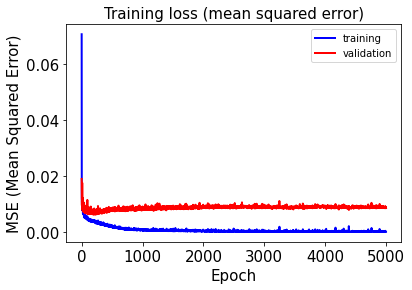

In [93]:
hist = history.history
plt.plot(hist['loss'], lw=2, c='b')
plt.plot(hist['val_loss'], lw=2, c='r')
plt.title('Training loss (mean squared error)', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('MSE (Mean Squared Error)', size=15)
plt.legend(['training', 'validation'])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

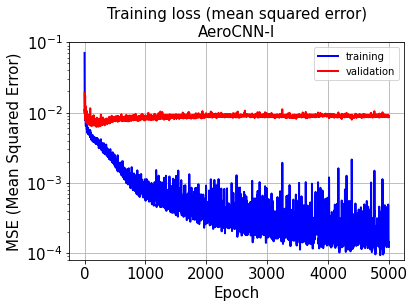

In [87]:
plt.plot(hist['loss'], lw=2, c='b')
plt.plot(hist['val_loss'], lw=2, c='r')
plt.title('Training loss (mean squared error)\nAeroCNN-I', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('MSE (Mean Squared Error)', size=15)
plt.yscale('log')
plt.ylim([8e-5, 1e-1])
plt.legend(['training', 'validation'])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

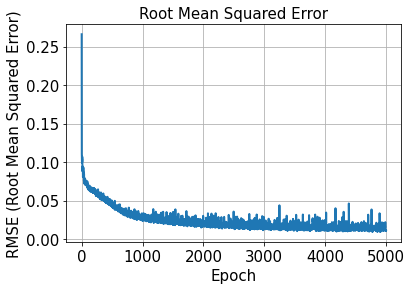

In [30]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('RMSE (Root Mean Squared Error)', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [31]:
test_results = model.evaluate([x_train,aa_train])

42/42 [==============================] - 0s 2ms/step - loss: 6.5737e-06 - rmse: 0.0000e+00


In [32]:
decoded_train = model.predict([x_train,aa_train])

42/42 [==============================] - 0s 2ms/step


In [33]:
decoded_val = model.predict([x_val,aa_val])

18/18 [==============================] - 0s 2ms/step


In [34]:
decoded_test = model.predict([x_test,aa_test])

7/7 [==============================] - 0s 2ms/step


In [35]:
error_train_abs = np.abs(decoded_train - y_train)

In [36]:
error_val_abs = np.abs(decoded_val - y_val)

In [37]:
error_test_abs = np.abs(decoded_test - y_test)

In [38]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [39]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [40]:
error_val_Cl_abs = np.abs(decoded_val[:,0,:] - y_val[:,0,:])

In [41]:
error_val_Cd_abs = np.abs(decoded_val[:,1,:] - y_val[:,1,:])

In [42]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [43]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [44]:
decoded_train.shape

(1328, 2, 1)

In [45]:
os.chdir("D:\\TrainedModels\\20220929")
model.save('AeroCNN-I_2FClayer_withValidationSet.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.02067553369165721


In [47]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.1740734590332649


In [48]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.19624225877319743


In [49]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.019508705130948382


In [50]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.04000372269832617


In [51]:
l2_error_Cl_val = np.sqrt(np.sum((decoded_val[:,0,:] - y_val[:,0,:])**2) / np.sum(y_val[:,0,:]**2))
print(l2_error_Cl_val)

0.16579681362105705


In [52]:
l2_error_Cd_val = np.sqrt(np.sum((decoded_val[:,1,:] - y_val[:,1,:])**2) / np.sum(y_val[:,1,:]**2))
print(l2_error_Cd_val)

0.3404047928759029


In [53]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.1928866796739614


In [54]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.2656020903200763


In [55]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.008717155444712571, 0.006828878144742022, 0.009497109781579473, 0.007988035225484963, 0.3360522097399697, 0.054913817724027904, 0.03701453263218568, 0.0239632572715854, 0.016430259363620907, 0.011846212186426518, 0.00737054592902121, 0.0042390317778373, 0.012845734751337034, 0.0022761806357205925, 0.02153998607834166, 0.016450828960987724, 0.0028179685829948647, 0.004912215230599406, 0.029895971208264923, 0.034608598143380194, 0.01559949049382342, 0.07470157267834124, 0.0118882444168856, 0.011595928928602383, 0.01056872276850373, 0.020160398325415652, 0.012286651717293885, 0.019485938135680787, 0.014404048602700158, 0.04652618488531283, 0.015002794485111597, 0.0030887114862149403, 0.030235466457128397, 0.03375158648770887, 0.0025894282036660814, 0.012589121033789213, 0.04557237823190258, 0.04078086007419345, 0.020440245770639975, 0.007490317751068993, 0.008286918783072953, 0.01095983274170226, 0.009412943656915237, 0.007199825080924383, 0.007943833957704897, 0.009923629638130286, 0.

In [56]:
l2_error_val_list = []
for i in range(0, len(aa_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum(y_val[i]**2))
    l2_error_val_list.append(l2_error_val_data)

In [57]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.04018981180586996, 0.02742458938682325, 0.05853168392542409, 0.06850961249183632, 0.10595685918741089, 0.3286423336151833, 0.07230762200213448, 0.021118951146533085, 0.09142688626455082, 0.017016268695313877, 0.3107761750996838, 0.056873104424115944, 0.07595014669776486, 0.030752658974015242, 0.19376377828663854, 0.12361654293463945, 0.02899291078416044, 0.06436911325074758, 0.061459334101274334, 0.07297118805279887, 0.28818130873471337, 0.11682603609046102, 0.14830435881844953, 0.0958561514334108, 0.06772198805881564, 0.05097560850362772, 0.04280876819524963, 0.014328757754712951, 0.017490886628439624, 0.2489902605089438, 0.43062578382045685, 0.4080806034743775, 0.02024260106015996, 0.06126303051254957, 0.025505665282971456, 0.09203532476932642, 0.24937242299633972, 0.8501255126503138, 0.2221482237803624, 0.1665435402141215, 0.13527904326058476, 0.14380526193130938, 0.7469069075625866, 0.23300652903166824, 0.05595145115491428, 0.17717320920926904, 0.11684691959032391, 0.08684190938

In [58]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.008348504971477584, 0.004471114491747454, 0.008346651560012639, 0.006408688912124796, 0.3725716661946059, 0.055025107788564384, 0.03704828399180164, 0.022207920823675457, 0.014147276245909394, 0.00887621047845362, 0.006286168474607975, 0.001491735177553737, 0.012536481804885412, 0.0005552569196006385, 0.021454726975516078, 0.011685636943319878, 0.0013914216642852786, 0.0011835668087265903, 0.029982033620174552, 0.03358149480559873, 0.005741196785230749, 0.1265262792197639, 0.007864827996319941, 0.011077633930963829, 0.007979811655041233, 0.0197293438267235, 0.012119399898595496, 0.011636810116045377, 0.004602327972474006, 0.04880921418497314, 0.00808261070075236, 0.003002825719143003, 0.028305768511547435, 0.03380117033512573, 0.0010753122503392534, 0.010716714397392253, 0.03621068386553444, 0.04130053257934781, 0.01847502178878485, 0.005417510058996322, 0.008282819544165541, 0.009899815769060284, 0.00941546849850983, 0.006103831231743436, 0.007785067679783081, 0.004779301037321418,

In [59]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.07249234284822859, 0.1530535722008175, 0.11088541455579247, 0.06927469556477756, 0.0988803788156466, 0.03914928491977661, 0.008327833499107349, 0.28579165109469334, 0.3007755877661661, 0.27334543972829023, 0.11402612239290706, 0.09064419703941573, 0.047846296054845625, 0.029654769373107306, 0.028785389886290678, 0.08393425520220603, 0.011383130277515736, 0.036212266485091106, 0.009075257732948252, 0.13703084416597267, 0.18196376899643965, 0.009263500502899903, 0.10800630710998271, 0.07112330771136488, 0.11581235542376436, 0.04477120426297246, 0.016003169032309684, 0.05916039311577904, 0.042955548716636545, 0.025952372104496906, 0.03418088916294826, 0.0035717076637937937, 0.05063378493033073, 0.022423702300374618, 0.05916415189209269, 0.12428954485298348, 0.2185804078149687, 0.018384399844501513, 0.1656752933034387, 0.15386056962566885, 0.012778120504380595, 0.19029086313113866, 0.00440416407050116, 0.11709551043208319, 0.03398893015089395, 0.09898404061127061, 0.017913669195673675, 

In [60]:
l2_error_Cl_val_list = []
for i in range(0, len(aa_val)):
    l2_error_Cl_val_data = np.sqrt(np.sum((decoded_val[:,0,:][i] - y_val[:,0,:][i])**2) / np.sum(y_val[:,0,:][i]**2))
    l2_error_Cl_val_list.append(l2_error_Cl_val_data)

In [61]:
l2_error_Cd_val_list = []
for i in range(0, len(aa_val)):
    l2_error_Cd_val_data = np.sqrt(np.sum((decoded_val[:,1,:][i] - y_val[:,1,:][i])**2) / np.sum(y_val[:,1,:][i]**2))
    l2_error_Cd_val_list.append(l2_error_Cd_val_data)

In [62]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.04115153341200031, 0.023707923095193727, 0.0557775695915697, 0.06766092588219555, 0.10439312848891166, 0.32923928841006, 0.07207811057928744, 0.015447332809354342, 0.09149681596861338, 0.007279056453831855, 0.31187077979358924, 0.0525294760120733, 0.07651675679815947, 0.02969090874961141, 0.19923307654877476, 0.12846374491270265, 0.028564410783235256, 0.063630385578445, 0.06003285043188673, 0.07180021722769939, 0.41249754330194455, 0.08748354413929293, 0.1459650457433039, 0.09578039179134834, 0.0676293529090477, 0.05065486536525165, 0.04266670236006032, 0.013549878642068485, 0.005675226458185384, 0.2496220190604926, 0.43639707765474745, 0.4407369852045639, 0.019531536417140005, 0.05669700364530829, 0.02222725081084441, 0.0920973254158407, 0.2504508522756345, 0.8655464361352432, 0.22204330027047517, 0.16662846689368072, 0.13503896234237636, 0.14245969196329172, 0.7496747709905729, 0.22024809929835631, 0.0578280300359511, 0.18077708456309152, 0.11655563859298257, 0.08156079433151073, 

In [63]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.010947361695571253, 0.08641863760590102, 0.24367398440434287, 0.21507644926992847, 0.2067486797850314, 0.3125581309143144, 0.13796540367074753, 0.4149556434950205, 0.029615556389109447, 0.21485014850148368, 0.2741739743735746, 0.1087151446056694, 0.0682921782453034, 0.03954895321083113, 0.13984231371608333, 0.08558562134413822, 0.15416961027605056, 0.29570687704789517, 0.3215422134198169, 0.19494965027459027, 0.04604890513351162, 0.9937333839365171, 0.6852704207441177, 0.16553001299286982, 0.160245405684674, 0.24361152828146107, 0.13849105376981433, 0.1392882304386683, 0.31388799850259047, 0.1739019242341372, 0.25814616939388124, 0.12015160429967353, 0.030355835178302724, 0.15956756191498034, 0.19293631877395293, 0.056831823871029925, 0.01404394936023947, 0.2801962447946318, 0.26134435170920317, 0.027223366835864404, 0.3016891080193452, 0.4354098903369078, 0.49262315360662884, 0.4078605491342798, 0.011936077570565307, 0.12864855150937665, 0.11937905973785129, 0.11771373191796072, 0.

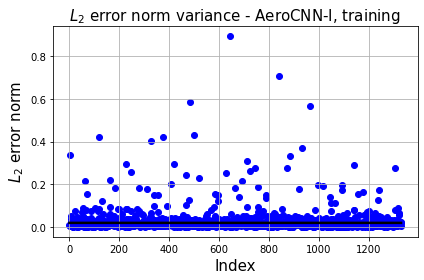

In [64]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, training', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

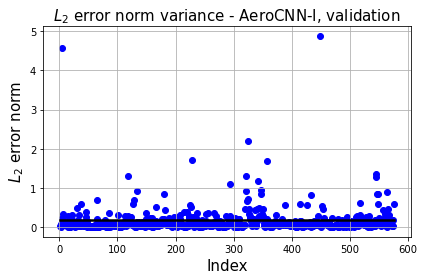

In [65]:
plt.plot(np.linspace(1, aa_val.shape[0], aa_val.shape[0]),
         l2_error_val*np.ones(aa_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_val.shape[0], aa_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, validation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

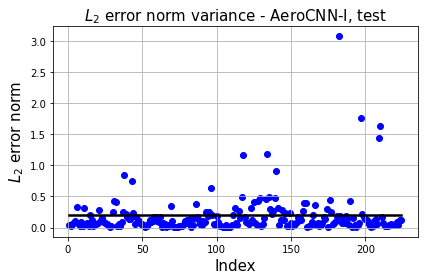

In [66]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

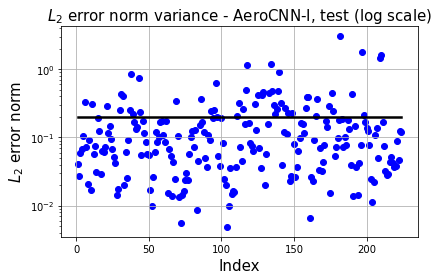

In [67]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

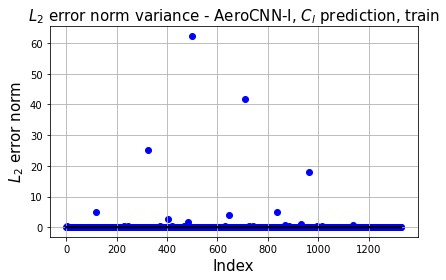

In [68]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

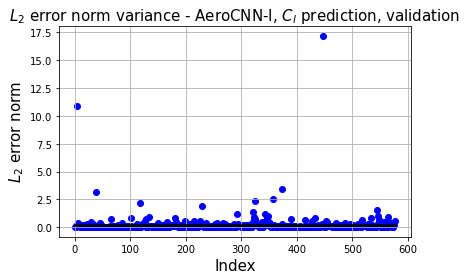

In [69]:
plt.plot(np.linspace(1, aa_val.shape[0], aa_val.shape[0]),
         l2_error_Cl_val*np.ones(aa_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_val.shape[0], aa_val.shape[0]), l2_error_Cl_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, validation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

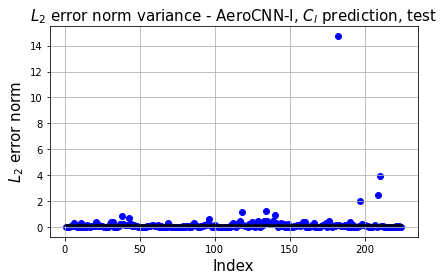

In [70]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

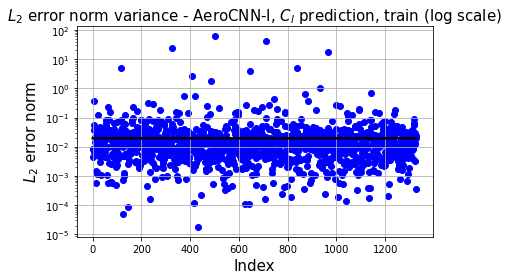

In [71]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

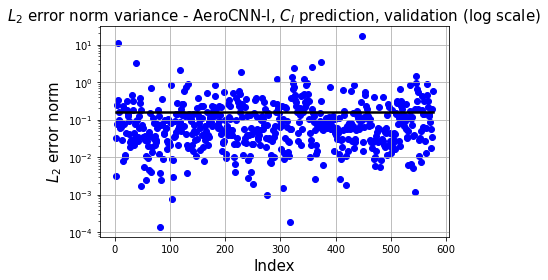

In [94]:
plt.plot(np.linspace(1, aa_val.shape[0], aa_val.shape[0]),
         l2_error_Cl_val*np.ones(aa_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_val.shape[0], aa_val.shape[0]), l2_error_Cl_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, validation (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

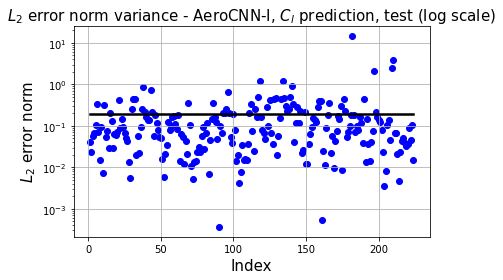

In [72]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

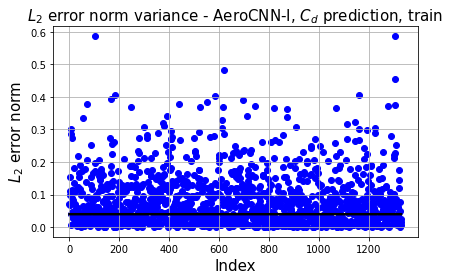

In [73]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

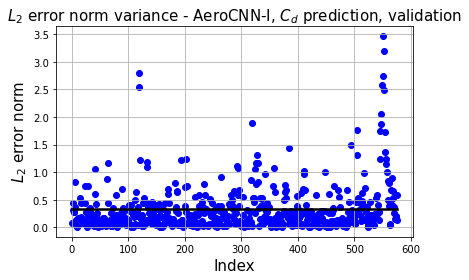

In [74]:
plt.plot(np.linspace(1, aa_val.shape[0], aa_val.shape[0]),
         l2_error_Cd_val*np.ones(aa_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_val.shape[0], aa_val.shape[0]), l2_error_Cd_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, validation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

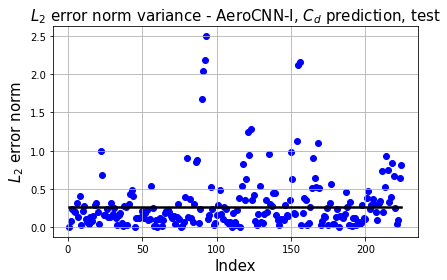

In [75]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

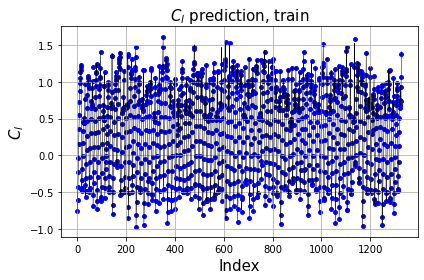

In [76]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

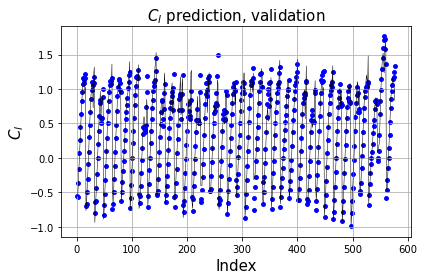

In [77]:
plt.plot(np.linspace(1, decoded_val.shape[0], decoded_val.shape[0]), y_val[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_val.shape[0], decoded_val.shape[0]), decoded_val[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, validation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

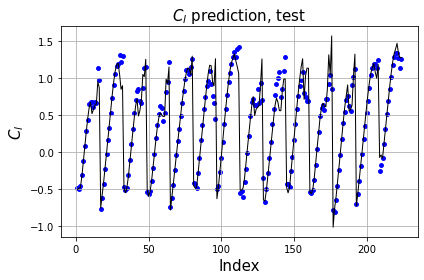

In [78]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

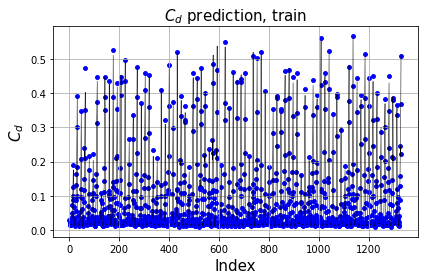

In [79]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

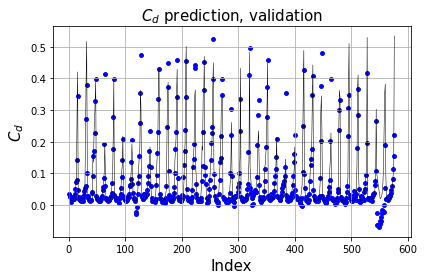

In [80]:
plt.plot(np.linspace(1, decoded_val.shape[0], decoded_val.shape[0]), y_val[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_val.shape[0], decoded_val.shape[0]), decoded_val[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, validation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

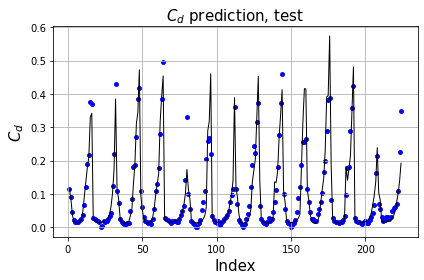

In [81]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

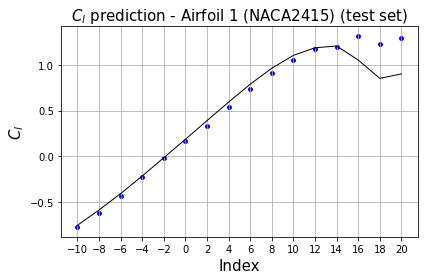

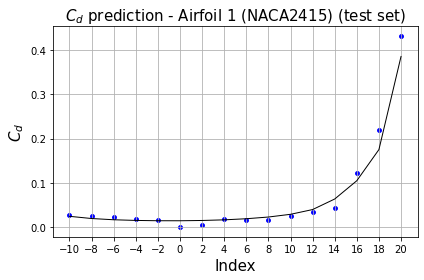

In [82]:
airfoiltest1_predict = decoded_test[16*1:16*2]

airfoiltest1_cl=y_test[16*1:16*2,0,:]
airfoiltest1_cd=y_test[16*1:16*2,1,:]

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 1 (%s) (test set)' % (str(geo_test[1*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 1 (%s) (test set)' % (str(geo_test[1*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [83]:
decoded_test.shape

(224, 2, 1)

In [84]:
np.unique(geo_test)

array([b'NACA001034', b'NACA1408', b'NACA2415', b'NACA2418', b'NACA63210',
       b'NACA632615', b'NACA64108', b'NACA6412', b'NACA64209', b'RAE101',
       b'RAE5212', b'RAE5214', b'RAE69CK', b'RAF48'], dtype='|S32')

In [85]:
geo_test.shape[0]/16

14.0

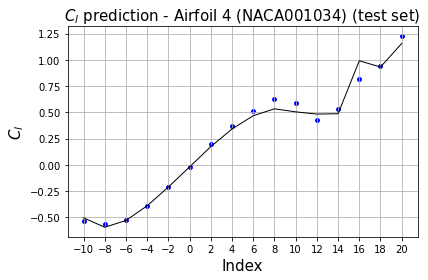

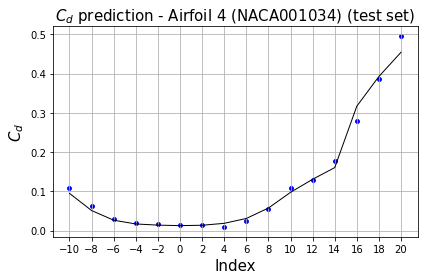

In [88]:
airfoiltest4_predict = decoded_test[16*3:16*4]

airfoiltest4_cl=y_test[16*3:16*4,0,:]
airfoiltest4_cd=y_test[16*3:16*4,1,:]

plt.plot(alpha, airfoiltest4_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest4_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 4 (%s) (test set)' % (str(geo_test[3*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest4_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest4_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 4 (%s) (test set)' % (str(geo_test[3*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

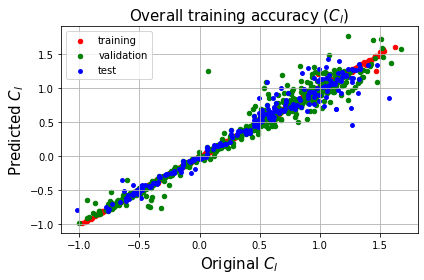

In [91]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_val[:,0,:], decoded_val[:,0,:], c='g', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)', fontsize=15)

plt.grid()
plt.legend(['training', 'validation', 'test'])
plt.tight_layout()
plt.show()

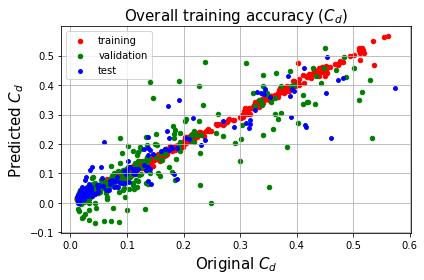

In [92]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_val[:,1,:], decoded_val[:,1,:], c='g', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)', fontsize=15)
plt.grid()
plt.legend(['training', 'validation', 'test'])
plt.tight_layout()
plt.show()

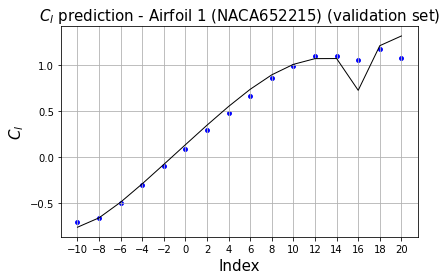

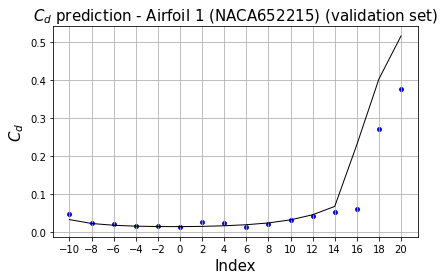

In [96]:
airfoiltest1_predict = decoded_val[16*1:16*2]

airfoiltest1_cl=y_val[16*1:16*2,0,:]
airfoiltest1_cd=y_val[16*1:16*2,1,:]

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 1 (%s) (validation set)' % (str(geo_val[1*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 1 (%s) (validation set)' % (str(geo_val[1*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [101]:
x_test.shape[0]/16

14.0